In [1]:
# !pip install -qq langgraph pyautogui

In [104]:
# GUI Automation with LangGraph and PyAutoGUI
import pyautogui
import base64
from io import BytesIO
from typing import Dict, Any, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, Annotated
import json
from openai import Client
import os
from PIL import Image
import matplotlib.pyplot as plt
from os import getenv

# Configure PyAutoGUI
pyautogui.FAILSAFE = True  # Move mouse to corner to stop
pyautogui.PAUSE = 0.5      # Pause between actions


client = Client(
    api_key=getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1"
)

In [105]:
# Define the state schema
class GraphState(TypedDict):
    tool_calls: list
    model: str
    reasoning_effort: str
    command: str                    # Human command
    screenshot: str                 # Base64 encoded screenshot
    reasoning_response: Dict[str, Any]  # Response from OpenAI
    img_dimensions: str
    action_result: str             # Result of executing the action
    messages: Annotated[list, add_messages]  # For tracking conversation


In [106]:
# Node 1: Take Screenshot
def take_screenshot_node(state: GraphState) -> GraphState:
    """Take a high-quality screenshot and encode it as base64."""
    print(f"📸 Taking high-quality screenshot for command: {state['command']}")
    
    # Take screenshot with the best available method
    screenshot = pyautogui.screenshot()
    print(f'The image is {screenshot.width}x{screenshot.height}')
    
    # Convert to base64 with maximum quality settings
    buffered = BytesIO()
    # Save as PNG with no compression for maximum quality
    screenshot.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")

    
    return {
        **state,
        "screenshot": img_str,
        "img_dimensions":f'The image is {screenshot.width}x{screenshot.height}',
        "messages": state.get("messages", []) + [{"role": "system", "content": "Enhanced high-quality screenshot taken successfully"}]
    }


In [107]:
# Define PyAutoGUI tools for OpenAI
pyautogui_tools = [
    {
        "type": "function",
        "function": {
            "name": "click",
            "description": "Click at specific coordinates on the screen",
            "parameters": {
                "type": "object",
                "properties": {
                    "x": {"type": "integer", "description": "X coordinate to click"},
                    "y": {"type": "integer", "description": "Y coordinate to click"}
                },
                "required": ["x", "y"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "double_click",
            "description": "Double click at specific coordinates on the screen",
            "parameters": {
                "type": "object",
                "properties": {
                    "x": {"type": "integer", "description": "X coordinate to double click"},
                    "y": {"type": "integer", "description": "Y coordinate to double click"}
                },
                "required": ["x", "y"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "type_text",
            "description": "Type text at the current cursor position",
            "parameters": {
                "type": "object",
                "properties": {
                    "text": {"type": "string", "description": "Text to type"}
                },
                "required": ["text"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "press_key",
            "description": "Press a specific key",
            "parameters": {
                "type": "object",
                "properties": {
                    "key": {"type": "string", "description": "Key to press (e.g., 'enter', 'tab', 'esc')"}
                },
                "required": ["key"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "hotkey",
            "description": "Press a hotkey combination",
            "parameters": {
                "type": "object",
                "properties": {
                    "keys": {"type": "array", "items": {"type": "string"}, "description": "Keys to press together (e.g., ['ctrl', 'c'])"}
                },
                "required": ["keys"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "scroll",
            "description": "Scroll at a specific location",
            "parameters": {
                "type": "object",
                "properties": {
                    "x": {"type": "integer", "description": "X coordinate to scroll at"},
                    "y": {"type": "integer", "description": "Y coordinate to scroll at"},
                    "clicks": {"type": "integer", "description": "Number of scroll clicks (positive for up, negative for down)"}
                },
                "required": ["x", "y", "clicks"]
            }
        }
    }
]


In [186]:
# Node 2: Reasoning with OpenAI Vision
def reasoning_node(state: GraphState) -> GraphState:
    """Send screenshot to OpenAI with tools for GUI automation."""
    print(f"🧠 Analyzing screenshot and planning action for: {state['command']}")
    
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": f"""\
You are a GUI automation assistant performing the action: 
                    
"{state['command']}"

Here is a screenshot of the current screen. {state["img_dimensions"]}
Use the available tools to perform the appropriate GUI action. Be precise with coordinates and choose the most appropriate action type.

First, reason through the screenshot provided and which tools you will need to accomplish the action.
Second, select a tool
"""
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{state['screenshot']}"
                    }
                }
            ]
        }
    ]
    try:
        extra_body={"include_reasoning": True, "reasoning_effort": state['reasoning_effort']}
        response = client.chat.completions.create(
            model=state['model'],
            messages=messages,
            tools=pyautogui_tools,
            extra_body=extra_body
        )
        
        return {
            **state,
            "reasoning_response": f'Reasoning: {response.choices[0].message.reasoning} || Answer: {response.choices[0].message.content}',
            "tool_calls": response.choices[0].message.tool_calls,
            "messages": state.get("messages", []) + [{"role": "system", "content": "OpenAI analysis completed"}]
        }
    
    except Exception as e:
        print(f"Error in reasoning: {e}")
        return {
            **state,
            "reasoning_response": {"error": str(e)},
            "messages": state.get("messages", []) + [{"role": "system", "content": f"Error in reasoning: {e}"}]
        }


In [187]:
# Node 3: Execute PyAutoGUI Action
def execute_action_node(state: GraphState) -> GraphState:
    """Execute the PyAutoGUI action determined by OpenAI."""
    print("⚡ Executing GUI action...")
    
    reasoning_response = state.get("reasoning_response", {})
    
    if "error" in reasoning_response:
        return {
            **state,
            "action_result": f"Error: {reasoning_response['error']}",
            "messages": state.get("messages", []) + [{"role": "system", "content": "Action execution failed due to reasoning error"}]
        }
    
    try:
        # Extract tool calls from OpenAI response
        tool_calls = state['tool_calls']

        
        if not tool_calls:
            # Check if AI provided reasoning without tools
            ai_message = reasoning_response.get("choices", [{}])[0].get("message", {}).get("content", "")
            action_result = f"No action determined by AI. Reasoning: {ai_message[:200]}..." if len(ai_message) > 200 else f"AI reasoning: {ai_message}"
            return {
                **state,
                "action_result": action_result,
                "messages": state.get("messages", []) + [{"role": "system", "content": "No tool calls found in response"}]
            }
        
        results = []
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            arguments = json.loads(tool_call.function.arguments)
            
            print(f"Executing {function_name} with args: {arguments}")
            
            # Execute the corresponding PyAutoGUI function
            if function_name == "click":
                pyautogui.click(arguments["x"], arguments["y"])
                results.append(f"Clicked at ({arguments['x']}, {arguments['y']})")
                
            elif function_name == "double_click":
                pyautogui.doubleClick(arguments["x"], arguments["y"])
                results.append(f"Double-clicked at ({arguments['x']}, {arguments['y']})")
                
            elif function_name == "type_text":
                pyautogui.write(arguments["text"])
                results.append(f"Typed: '{arguments['text']}'")
                
            elif function_name == "press_key":
                pyautogui.press(arguments["key"])
                results.append(f"Pressed key: {arguments['key']}")
                
            elif function_name == "hotkey":
                pyautogui.hotkey(*arguments["keys"])
                results.append(f"Pressed hotkey: {' + '.join(arguments['keys'])}")
                
            elif function_name == "scroll":
                pyautogui.scroll(arguments["clicks"], x=arguments["x"], y=arguments["y"])
                results.append(f"Scrolled {arguments['clicks']} clicks at ({arguments['x']}, {arguments['y']})")
            
            else:
                results.append(f"Unknown function: {function_name}")
        
        action_result = "; ".join(results)
        
        return {
            # **state,
            "action_result": action_result,
            "messages": state.get("messages", []) + [{"role": "system", "content": f"Actions executed: {action_result}"}]
        }
        
    except Exception as e:
        error_msg = f"Error executing action: {str(e)}"
        print(error_msg)
        return {
            **state,
            "action_result": error_msg,
            "messages": state.get("messages", []) + [{"role": "system", "content": error_msg}]
        }


In [188]:
# Create the LangGraph workflow
def create_gui_automation_graph():
    """Create and return the GUI automation workflow graph."""
    
    # Create the graph
    workflow = StateGraph(GraphState)
    
    # Add nodes
    workflow.add_node("take_screenshot", take_screenshot_node)
    workflow.add_node("reasoning", reasoning_node)
    workflow.add_node("execute_action", execute_action_node)
    
    # Define the flow
    workflow.add_edge(START, "take_screenshot")
    workflow.add_edge("take_screenshot", "reasoning")
    workflow.add_edge("reasoning", "execute_action")
    workflow.add_edge("execute_action", END)
    
    # Compile the graph
    app = workflow.compile()
    return app

# Create the automation graph
automation_graph = create_gui_automation_graph()


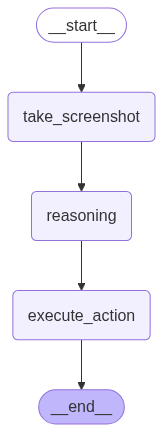

In [212]:
# Visualize the LangGraph workflow
from IPython.display import display
from IPython.display import Image as PImage

# Required graphviz to be available
graph_image = automation_graph.get_graph().draw_mermaid_png()
display(PImage(graph_image))

In [206]:
# Main function to execute GUI automation
def execute_gui_command(command: str, model: str, reasoning_effort: str):
    """Execute a GUI automation command using the LangGraph workflow."""
    
    print(f"🚀 Starting GUI automation for: '{command}'")
    print("=" * 50)
    
    # Initial state
    initial_state = {
        "model": model,
        "reasoning_effort": reasoning_effort,
        "command": command,
        "screenshot": "",
        "reasoning_response": {},
        "action_result": "",
        "messages": []
    }
    
    # Execute the workflow
    result = automation_graph.invoke(initial_state)
    
    print("=" * 50)
    print("✅ Automation completed!")
    print(f"Command: {result['command']}")
    
    # Display AI reasoning content
    reasoning_response = result.get('reasoning_response', {})
    print(f"\n🧠 AI Reasoning:")
    print(f"{reasoning_response}")
    
    print(f"\n⚡ Action Result: {result['action_result']}")
    
    # Display screenshot in high definition
    print(f"\n📸 Screenshot captured:")
    screenshot_data = base64.b64decode(result['screenshot'])

    # Open image with PIL
    screenshot_img = Image.open(BytesIO(screenshot_data))

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(screenshot_img)
    plt.axis('off')
    plt.show()

    
    return result


🚀 Starting GUI automation for: 'click on 'AGI Demystified' google slides tab'
📸 Taking high-quality screenshot for command: click on 'AGI Demystified' google slides tab
The image is 3024x1964
🧠 Analyzing screenshot and planning action for: click on 'AGI Demystified' google slides tab
⚡ Executing GUI action...
Executing click with args: {'x': 109, 'y': 380}
✅ Automation completed!
Command: click on 'AGI Demystified' google slides tab

🧠 AI Reasoning:
Reasoning: I need to analyze the screenshot to find the 'AGI Demystified' Google Slides tab to click on it.

Looking at the screenshot, I can see this is a macOS desktop with Arc browser open. There's a Jupyter notebook running in a browser tab, and I can see the sidebar on the left shows various tabs/bookmarks including:

- cais/hle - Discussions
- Artificial General Intellig...
- AGI Demystified - Live... (with docs.google.com underneath)
- computer_use_reasoning (appears to be selected/highlighted with a dashed box around it)
- intro_to_

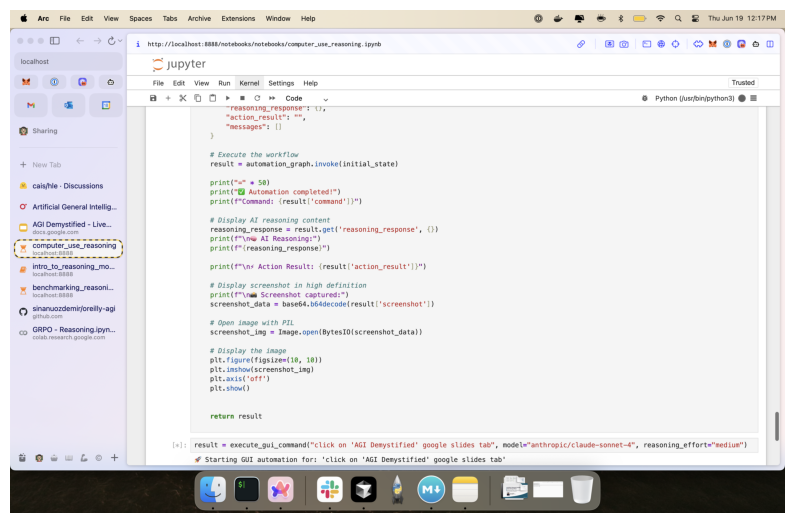

In [213]:
result = execute_gui_command("click on 'AGI Demystified' google slides tab", model="anthropic/claude-sonnet-4", reasoning_effort="medium")